In [1]:
import argparse
import torch
import torch.nn as nn
import dataa
import utils
import model
import numpy as np
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

### 1. Default Setting

1. Domain: 100 x 256 ($x \in [-1,1]$ and $t \in [0,1]$)

2. Collocation points: $N_{ic}=256$ and $N_{f}=25600$

3. Optimizer: Adam with the learning rate of $10^{-3}$


In [36]:
num_t = 100
num_x = 256
num_epochs = 20000
num_hidden = 4
num_nodes = 128
lr = 1e-3

In [44]:
# Select a partial differential equation
eq = 'bg' # or 'bg'

### 2. Train Data

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Operation mode: ", device)

Operation mode:  cuda:0


In [46]:
if eq == 'bg':
    t_data, x_data, u_data, t_data_f, x_data_f = dataa.bg_generator(num_t, num_x)
elif eq == 'ac':
    t_data, x_data, u_data, t_data_f, x_data_f = dataa.ac_generator(num_t, num_x)
else:
    print("There exists no the equation.")
    exit(0)

In [47]:
variables = torch.FloatTensor(np.concatenate((t_data, x_data), 1)).to(device)
variables_f = torch.FloatTensor(np.concatenate((t_data_f, x_data_f), 1)).to(device)
variables_f.requires_grad = True
u_data = torch.FloatTensor(u_data).to(device)

### 3. Neural Network

In [48]:
layer_list = [2] + num_hidden * [num_nodes] + [1]
pinn = model.pinn(layer_list).to(device)

### 4. Training Session

In [49]:
optimizer = torch.optim.Adam(pinn.parameters(), betas=(0.999,0.999), lr=lr)
loss_graph = []
ls = 1e-3
bep = 0

In [50]:
for ep in tqdm(range(num_epochs)):

        optimizer.zero_grad()

        # Full batch
        u_hat = pinn(variables)
        u_hat_f = pinn(variables_f)

        if eq == 'bg':
            loss_f = torch.mean(utils.burgers_equation(u_hat_f, variables_f) ** 2)
        elif eq == 'ac':
            loss_f = torch.mean(utils.ac_equation(u_hat_f, variables_f) ** 2)

        loss_u = torch.mean((u_hat - u_data) ** 2)
        loss = loss_f + loss_u
        loss.backward()
        optimizer.step()

        l = loss.item()
        loss_graph.append(l)
        if l < ls:
            ls = l
            bep = ep
            torch.save(pinn.state_dict(), './'+eq+'_1d.pth')

        if ep % 1000 == 0:
            print(f"Train loss: {l}")

  0%|          | 6/20000 [00:00<11:34, 28.78it/s]

Train loss: 0.368366003036499


  5%|▌         | 1006/20000 [00:29<09:07, 34.70it/s]

Train loss: 0.10795634984970093


 10%|█         | 2006/20000 [00:57<08:36, 34.83it/s]

Train loss: 0.08173620700836182


 15%|█▌        | 3006/20000 [01:26<08:08, 34.82it/s]

Train loss: 0.06540466845035553


 20%|██        | 4006/20000 [01:55<07:37, 34.98it/s]

Train loss: 0.028580253943800926


 25%|██▌       | 5006/20000 [02:24<07:10, 34.79it/s]

Train loss: 0.00965437013655901


 30%|███       | 6006/20000 [02:53<06:49, 34.18it/s]

Train loss: 0.004407090600579977


 35%|███▌      | 7006/20000 [03:21<06:12, 34.90it/s]

Train loss: 0.0021604816429316998


 40%|████      | 8006/20000 [03:50<05:44, 34.79it/s]

Train loss: 0.000987667590379715


 45%|████▌     | 9006/20000 [04:19<05:31, 33.12it/s]

Train loss: 0.0004957417258992791


 50%|█████     | 10006/20000 [04:48<04:51, 34.30it/s]

Train loss: 0.0002994526003021747


 55%|█████▌    | 11006/20000 [05:17<04:20, 34.51it/s]

Train loss: 0.0001699909335002303


 60%|██████    | 12006/20000 [05:47<03:53, 34.21it/s]

Train loss: 9.98129034996964e-05


 65%|██████▌   | 13006/20000 [06:16<03:23, 34.45it/s]

Train loss: 6.0272686823736876e-05


 70%|███████   | 14006/20000 [06:45<02:53, 34.56it/s]

Train loss: 3.9585840568179265e-05


 75%|███████▌  | 15006/20000 [07:14<02:25, 34.28it/s]

Train loss: 2.5171273591695353e-05


 80%|████████  | 16006/20000 [07:43<01:55, 34.45it/s]

Train loss: 1.554854134155903e-05


 85%|████████▌ | 17006/20000 [08:13<01:29, 33.44it/s]

Train loss: 9.157400199910626e-06


 90%|█████████ | 18006/20000 [08:42<00:57, 34.62it/s]

Train loss: 5.375284672481939e-06


 95%|█████████▌| 19006/20000 [09:11<00:28, 34.57it/s]

Train loss: 3.750345740627381e-06


100%|██████████| 20000/20000 [09:39<00:00, 34.49it/s]


[Best][Epoch: 19983] Train loss: 2.511419552320149e-06


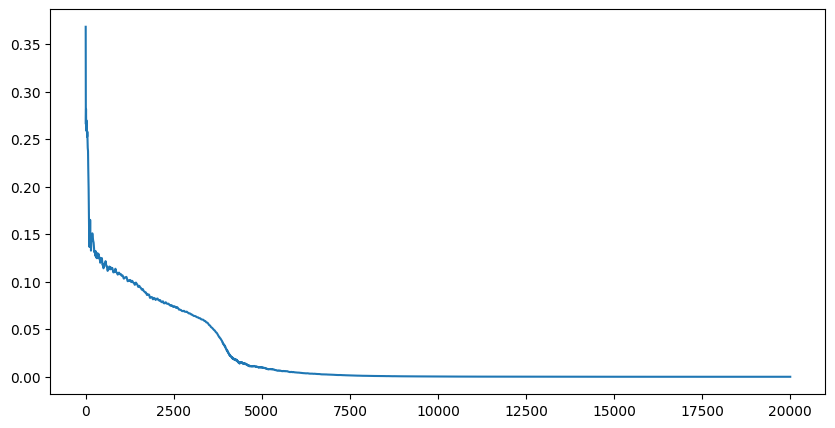

In [52]:
print(f"[Best][Epoch: {bep}] Train loss: {ls}")
plt.figure(figsize=(10, 5))
plt.plot(loss_graph)
plt.show()

### 5. Inference Session

In [53]:
pinn.load_state_dict(torch.load('./'+eq+'_1d.pth'))

<All keys matched successfully>

In [55]:
if eq == 'bg':
    t_test, x_test = dataa.bg_generator(101, 256, typ='test')
    t = np.linspace(0, 1, 101).reshape(-1,1)
    x = np.linspace(-1, 1, 256).reshape(-1,1)
    T = t.shape[0]
    N = x.shape[0]
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    data = scipy.io.loadmat('./data/burgers_shock.mat')
    Exact = np.real(data['usol'])
    err = u_pred[:,:-1]-Exact

elif eq == 'ac':
    t = np.linspace(0, 1, 201).reshape(-1,1) # T x 1
    x = np.linspace(-1, 1, 513)[:-1].reshape(-1,1) # N x 1
    T = t.shape[0]
    N = x.shape[0]
    T_star = np.tile(t, (1, N)).T  # N x T
    X_star = np.tile(x, (1, T))  # N x T
    t_test = T_star.flatten()[:, None]
    x_test = X_star.flatten()[:, None]

    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    data = scipy.io.loadmat('./data/AC.mat')
    Exact = np.real(data['uu'])
    err = u_pred-Exact

err = np.linalg.norm(err,2)/np.linalg.norm(Exact,2)
print(f"L2 Relative Error: {err}")

L2 Relative Error: 0.004376594731776944


### 6. Result Figures

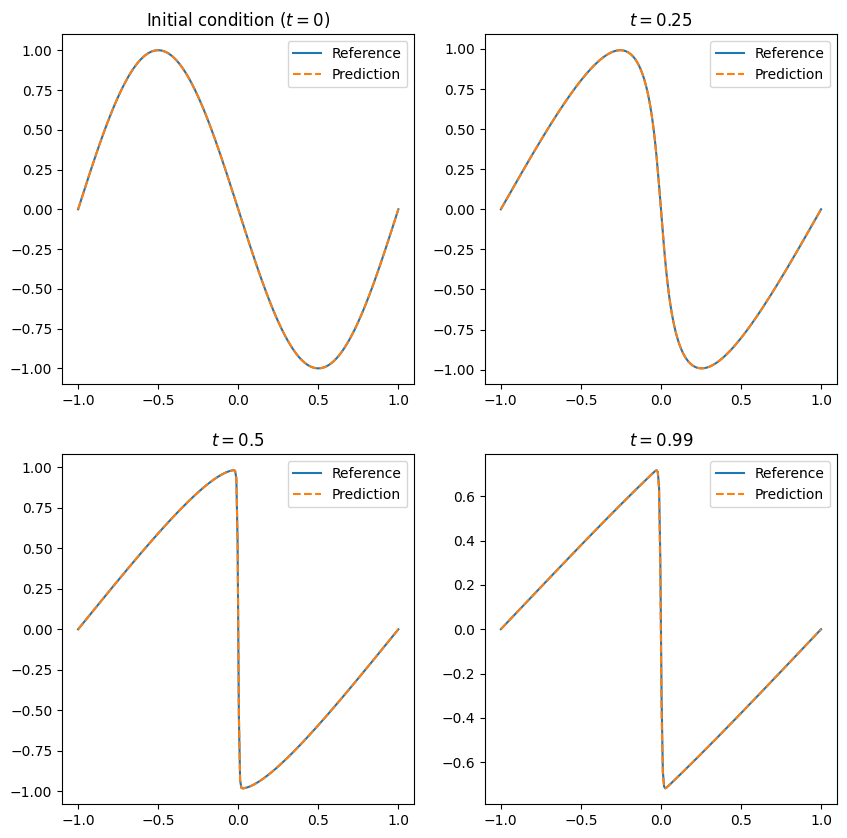

In [56]:
utils.resplot(x, t, t_data, x_data, Exact, u_pred)

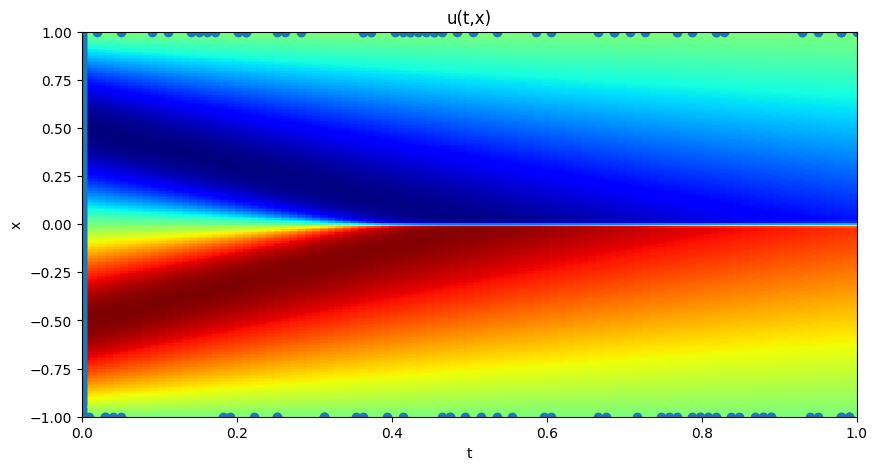

In [57]:
plt.figure(figsize=(10, 5))
plt.imshow(u_pred, interpolation='nearest', cmap='jet',
            extent=[t.min(), t.max(), x.min(), x.max()],
            origin='lower', aspect='auto')
plt.clim(-1, 1)
plt.ylim(-1,1)
plt.xlim(0,1)
plt.scatter(t_data, x_data)
plt.xlabel('t')
plt.ylabel('x')
plt.title('u(t,x)')
plt.show()

In [64]:
!zip -r /content . -i content.zip

	zip warning: zip file empty
